##GAN&CLIP&GA - IMAGENET EVALUATION - USING FINAL IMAGES

Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [1]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt #imagenet_classes

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout main ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math
from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators, get_algo


warnings.filterwarnings('ignore')

In [2]:
# CHOOSE ONE OF THE IMAGENET CLASSES AND PASTE IN THE "TARGET" FIELD BELOW
with open("/content/imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]
print(categories)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

In [3]:
#@title Input Parameters
target = "a cat" #@param {type:"string"}
config = "DeepMindBigGAN256_ga" #@param ["DeepMindBigGAN256_ga","DeepMindBigGAN256_de", "StyleGAN2_ffhq_ga","StyleGAN2_ffhq_de", "StyleGAN2_car_ga", "StyleGAN2_car_de","StyleGAN2_church_ga", "StyleGAN2_church_de","StyleGAN2_cat_ga", "StyleGAN2_cat_de"]
generations =   40#@param {type:"number"}
callbacks_each =  10 #@param {type: "number"}
population_size =  64#@param {type:"number"}
number_of_loops =  1 #@param {type:"number"}

In [4]:
#@title Download weights for given model
!chmod +x ./download-weights.sh
if "ffhq" in config:
  ! ./download-weights.sh StyleGAN2-ffhq
if "church" in config:
  ! ./download-weights.sh StyleGAN2-church
if "car" in config:
  ! ./download-weights.sh StyleGAN2-car
if "cat" in config:
  ! ./download-weights.sh StyleGAN2-cat

In [5]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
# config.algorithm = algorithm_param
config.generations = generations

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')


In [8]:
#@title Support methods

def callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)

def generate_image(loop: int):
  problem = GenerationProblem(config)

  kwargs = get_algo(config)

  algorithm = get_algorithm(
      config.algorithm,
      callback=callback,
      **kwargs
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=True,
  )
  

  X = np.atleast_2d(res.X) # for config.n_obj==1
  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)
  print(f'Final image for "{config.target}" target - loop {loop}.')
  problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/loop_{loop}.jpg")
  display(Image(f"./{config.tmp_folder}/{config.target}/loop_{loop}.jpg"))

n_gen |  n_eval |   cv (min)   |   cv (avg)   |     fopt     |     favg    
    1 |      64 |  0.00000E+00 |  0.00000E+00 |      -0.2627 |      -0.2228
    2 |     128 |  0.00000E+00 |  0.00000E+00 |      -0.2627 |      -0.2365
    3 |     192 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2415
    4 |     256 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2444
    5 |     320 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2487
    6 |     384 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |       -0.251
    7 |     448 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2527
    8 |     512 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2544
    9 |     576 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |       -0.257
   10 |     640 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2585
   11 |     704 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2595
   12 |     768 |  0.00000E+00 |  0.00000E+00 |      -0.2866 |      -0.2607
   13 |     

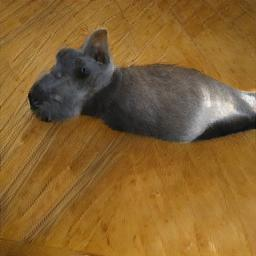

In [9]:
#@title RUN (GENERATE IMAGES)


for loop in tqdm_notebook(range(number_of_loops)):
  iteration=0
  generate_image(loop)

### RESNET - CLASS EVALUATION

In [10]:
#@title RESNET initialization
%%capture
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
model.eval()

import PIL
from torchvision import transforms



Accuracy for A CAT class: 0.0%, (0/1)

Images' details:


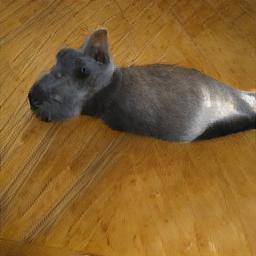

TOP 5 predicted categories:
Scotch terrier 72.61%
giant schnauzer 5.72%
miniature schnauzer 2.82%
standard schnauzer 2.2%
cairn 1.53%



In [11]:
#@title RUN - EVALUATE CLASS
class_to_check = target

with open("/content/imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

list_of_images = []
for (dirpath, dirnames, filenames) in os.walk(f'/content/clip_gans/{config.tmp_folder[2:]}/{class_to_check}'):
    list_of_images += [os.path.join(dirpath, file) for file in filenames]


acc_count = 0
for image_path in tqdm_notebook(list_of_images):
  input_image = PIL.Image.open(image_path)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to('cuda')
  model.to('cuda')
  with torch.no_grad():
    output = model(input_batch)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)

  top_prob, top_catid = torch.topk(probabilities, 1)
  predicted_label = categories[top_catid[0]]

  if predicted_label==class_to_check:
    acc_count += 1
  
print(f'\nAccuracy for {class_to_check.upper()} class: {round(acc_count/len(list_of_images)*100, 2)}%, ({acc_count}/{len(list_of_images)})')
print("\nImages' details:")

for image_path in list_of_images:
  input_image = PIL.Image.open(image_path)
  display(input_image)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to('cuda')
  model.to('cuda')
  with torch.no_grad():
    output = model(input_batch)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)

  top_prob, top_catid = torch.topk(probabilities, 5)

  print('TOP 5 predicted categories:')
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], f'{round(top5_prob[i].item()*100, 2)}%')
  print("")